In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# analog_file = r"C:\Users\neurogears\Documents\git\neurogears\sarahe-vr-2p\analysis\data\AnalogInput.bin"
analog_file = r"C:\\Mouse2\\2023-06-30T16-41-54\AnalogInput.bin"
fs_analog = 1000 #samples per second
digital_file =r"C:\\Mouse2\\2023-06-30T16-41-54\DigitalInput.bin"
fs_digital = 3000 #samples per second

In [54]:
analog_data = np.fromfile(analog_file, dtype=np.float64).reshape(-1,3).transpose()
# for i in range(analog_data.shape[0]): 
#     plt.figure()
#     plt.plot(analog_data[i,:])
#     plt.show()

analog_photodiode = analog_data[0,:] # specify input
photodiode_thresholded = (analog_photodiode > 0.3).astype(int) # set arbitrary threshold
rising_edges = np.where(np.diff(photodiode_thresholded) == 1)[0] # identify where in time frame signal
analog_time = np.arange(analog_photodiode.shape[0])/fs_analog #change time scale

# plot figure
# plt.figure(figsize=(20,10))
# plt.plot(analog_time, analog_photodiode)
# plt.scatter(rising_edges / fs_analog, rising_edges*0 + 1, c='r', s=10)
# plt.xlim((0, 5))
# plt.show()
print(rising_edges)



[ 1634  1875  3359  4419  6023  7468 11161 11879 14467 18541 21388 23711
 24215 24298 30510 32215 34184 47601 48187 49066 51234 52519 53661 54485
 59519 60558]


In [4]:
def extract_digital_channel(digital_data, channel_number):
     #channel_number goes from 0 to 7
     return digital_data & (1 << channel_number) > 0

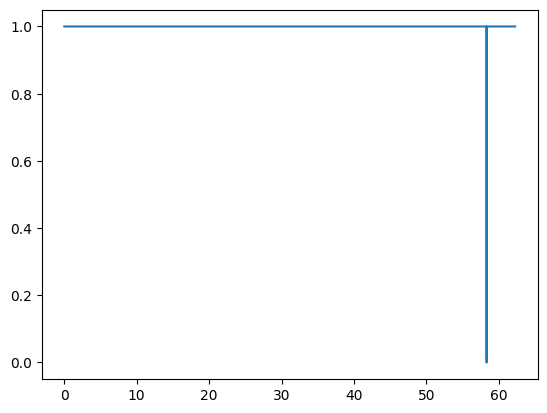

In [138]:
digital_data = np.fromfile(digital_file, dtype=np.byte)
digital_time = np.arange(digital_data.shape[0])/fs_digital


# plt.figure()
# plt.plot(digital_time, digital_data)
# plt.show()

plt.figure()
plt.plot(digital_time, extract_digital_channel(digital_data, 2))
plt.show()


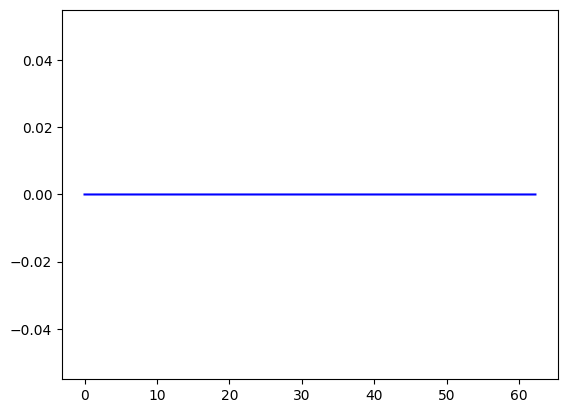

In [146]:
plt.figure()
# plt.plot(analog_time, analog_photodiode/5, c = "r") # divide by 5 for visualization purposes
plt.plot(digital_time, extract_digital_channel(digital_data, 8), c = "b")
plt.show()

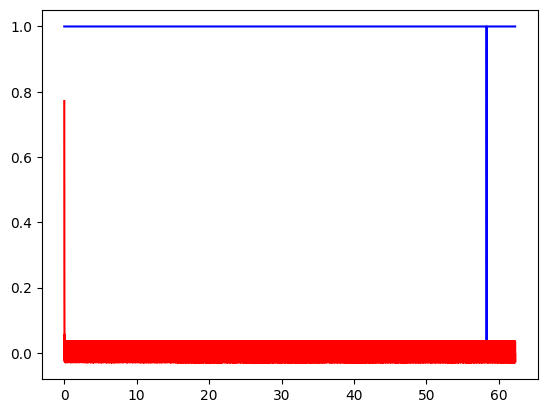

In [171]:
## align and concatenate all digital and analog data

aligned_data = np.zeros(len(digital_time), dtype=[('Timestamp', float), ('Analog_Data0', float), ('Analog_Data1', float), ('Analog_Data2', float),
                                                  ('Digital_Data0', int), ('Digital_Data1', int), ('Digital_Data2', int),('RotaryEncoder',float)])
aligned_data['Timestamp'] = digital_time
for i in range(len(analog_data)):
    aligned_data['Analog_Data'+ str(i)] = analog_data[i,:][np.searchsorted(analog_time,digital_time)]

aligned_data['Digital_Data0']= extract_digital_channel(digital_data, 2)  
aligned_data['Digital_Data1']= extract_digital_channel(digital_data, 4)  
aligned_data['Digital_Data2']= extract_digital_channel(digital_data, 6)  

# plt.figure()
# plt.plot(aligned_data['Timestamp'],aligned_data['Digital_Data0'], c = "b")
# plt.plot(aligned_data['Timestamp'],aligned_data['Analog_Data2'], c = "r")
# plt.show()



In [189]:
## load csv files and align to existing array
csv_file = r"C:\\Mouse2\\2023-06-30T16-41-54\RotaryEncoder.csv"  # 
df = pd.read_csv(csv_file)
csv_timestamps=df['RenderElapsedTime'].values
csv_values=df['RotaryEncoder'].values
csv_aligned_values = np.full(len(aligned_data), np.nan)
csv_indices = np.searchsorted(aligned_data['Timestamp'], csv_timestamps)
csv_aligned_values[csv_indices] = csv_values
aligned_data['RotaryEncoder'] = csv_aligned_values

[(0.00000000e+00,  0.00872436, 0.00083524,  0.77166847, 1, 0, 0, nan)
 (3.33333333e-04, -0.00442417, 0.00083524,  0.70263859, 1, 0, 0, nan)
 (6.66666667e-04, -0.00442417, 0.00083524,  0.70263859, 1, 0, 0, nan) ...
 (6.22656667e+01,  0.02581746, 0.00083524, -0.01231329, 1, 0, 1, nan)
 (6.22660000e+01,  0.02581746, 0.00083524, -0.01231329, 1, 0, 1, nan)
 (6.22663333e+01,  0.09649084, 0.00116395, -0.00442417, 1, 0, 1, nan)]
